# Project 2

# Purpose

This [November 2021 CNBC article](https://www.cnbc.com/2021/11/09/bitcoin-vs-gold-leading-gold-authorities-on-inflation-hedge-battle.html) on Bitcoin and gold as inflation and market risk hedges motivated this project.
I have two goals for this project:

1. To help you master data analysis
1. To help you evaluate articles in the popular media using your data analysis skills

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
%precision 2
%config InlineBackend.figure_format = 'retina'

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
get_ipython().run_line_magic('precision', '2')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

In [4]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [5]:
import scipy.optimize as sco
import seaborn as sns
import statsmodels.formula.api as smf

# Tasks

## Task 1: Do Bitcoin and gold hedge inflation risk?

Use the typical finance definition of [hedge](https://www.investopedia.com/terms/h/hedge.asp):

> To hedge, in finance, is to take an offsetting position in an asset or investment that reduces the price risk of an existing position. A hedge is therefore a trade that is made with the purpose of reducing the risk of adverse price movements in another asset. Normally, a hedge consists of taking the opposite position in a related security or in a derivative security based on the asset to be hedged. 

Here are a few suggestions:

1. Measure Bitcoin's price with [BTC-USD](https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD&.tsrc=fin-srch) and gold's price with [GLD](https://finance.yahoo.com/quote/GLD?p=GLD&.tsrc=fin-srch)
1. Throughout the project, assume Bitcoin and U.S. public equity markets have the same closing time
1. Measure the price level with [PCEPI](https://fred.stlouisfed.org/series/PCEPI/) from the Federal Reserve Database (FRED), which is downloadable with `pdr.DataReader()`
1. Measure inflation (i.e., the rate of change in the price level) as the percent change in PCEPI

In [6]:
# Calculate the daily return of bitcoin
btc = yf.download('BTC-USD', progress=False)['Adj Close'].pct_change()
# Calculate the daily return of gold
gld = yf.download('GLD', progress=False)['Adj Close'].pct_change()
# Calculate the monthiy return of bitcoin and gold
btc_m = pd.DataFrame(btc.resample('M').apply(lambda x: (1+x).prod()-1))
gld_m = pd.DataFrame(gld.resample('M').apply(lambda x: (1+x).prod()-1))
btc_m.columns = ['Monthly Returns on BTC']
gld_m.columns = ['Monthly Returns on GLD']

In [7]:
btc_m.head()

,Monthly Returns on BTC
Date,
2014-09-30,-0.15
2014-10-31,-0.13
2014-11-30,0.12
2014-12-31,-0.15
2015-01-31,-0.32


In [8]:
gld_m.head()

,Monthly Returns on GLD
Date,
2004-11-30,0.02
2004-12-31,-0.03
2005-01-31,-0.04
2005-02-28,0.03
2005-03-31,-0.02


In [9]:
# Download PCEPI from FRED, calculate the inflation
inf = (pdr.DataReader(
    name = 'PCEPI',
    data_source = 'fred', 
    start='2015',
    session = session
)
       .dropna()
       .pct_change()
      )
inf.columns = ['Inflation']

# To evaluate the hedge effectiveness of Bitcoin and gold against inflation
delta_inf = inf.pct_change()
delta_inf.columns = ['Delta Inflation']
delta_inf = delta_inf.rename_axis('Date')

In [10]:
# Combine the monthly returns of Bitcoin with the changes in inflation and compute the correlation between these two sets of data.
btc_h_inf = (
    pd.merge_asof(
        left = btc_m,
        right=delta_inf,
        on='Date',
        direction = 'forward',
        allow_exact_matches = False
    )
    .set_index(['Date'])
)   

In [11]:
btc_h_inf.corr()

,Monthly Returns on BTC,Delta Inflation
Monthly Returns on BTC,1.00,0.13
Delta Inflation,0.13,1.00


Text(0.5, 1.0, 'Return on Bitcon and Change of Inflation')

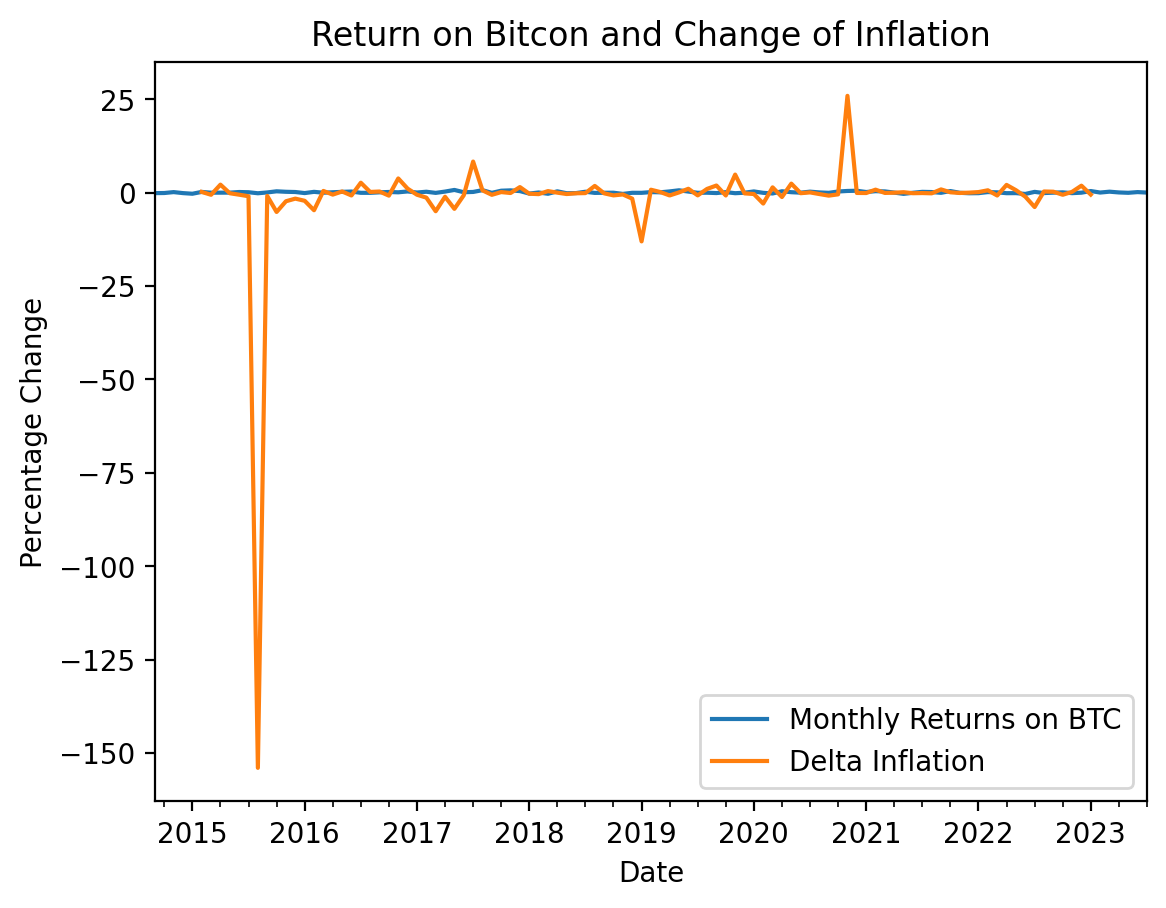

In [12]:
btc_h_inf.plot()
plt.ylabel('Percentage Change')
plt.title('Return on Bitcon and Change of Inflation')

In [13]:
# Combine the monthly returns of Gold with the changes in inflation and compute the correlation between these two sets of data.
gld_h_inf = (
    pd.merge_asof(
        left = gld_m,
        right=delta_inf,
        on='Date',
        direction = 'forward',
        allow_exact_matches = False
    )
    .set_index(['Date'])
)   

In [14]:
gld_h_inf.corr()

,Monthly Returns on GLD,Delta Inflation
Monthly Returns on GLD,1.00,-0.12
Delta Inflation,-0.12,1.00


Text(0.5, 1.0, 'Return on Gold and Change of Inflation')

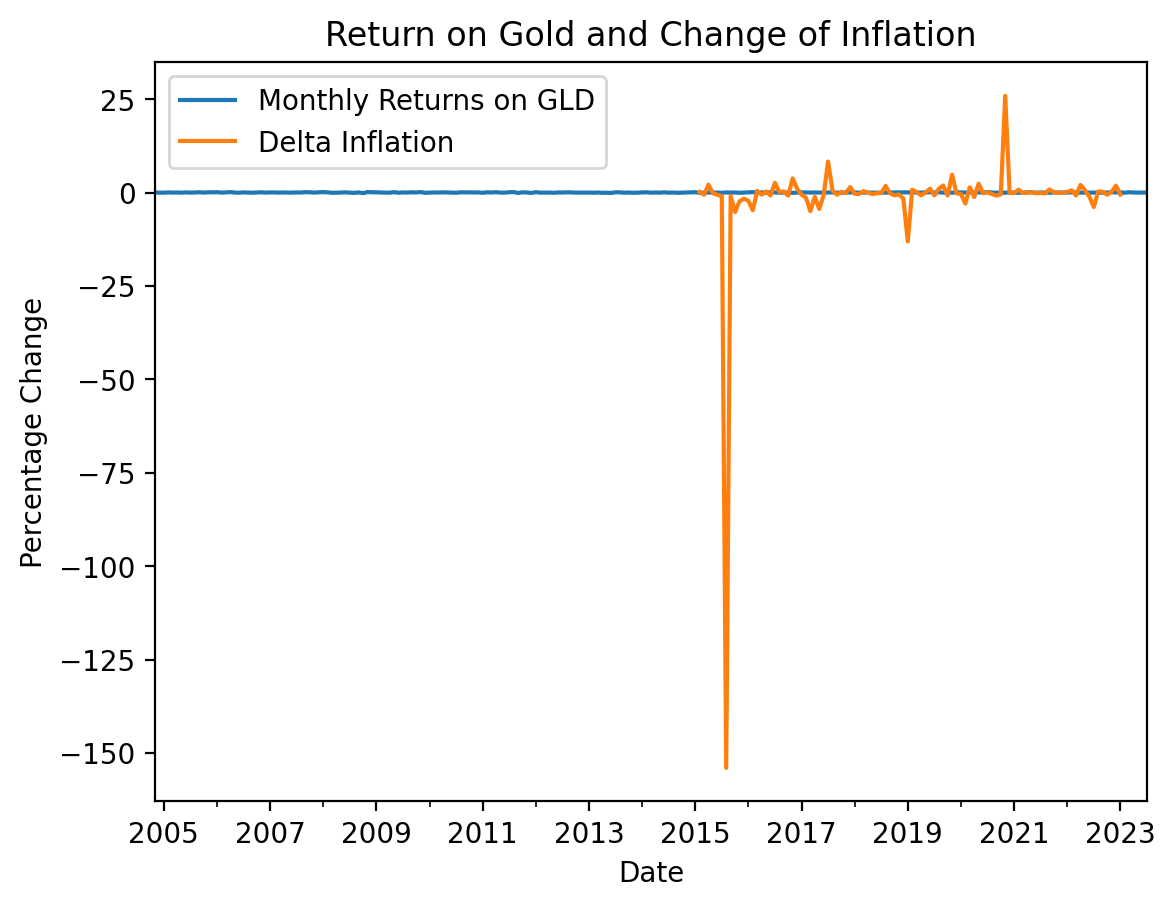

In [15]:
gld_h_inf.plot()
plt.ylabel('Percentage Change')
plt.title('Return on Gold and Change of Inflation')

According to the analysis, both bitcoin and gold are not considered to be a good hedges against inflation. In our analysis above, we have calculated the correlation between Gold and Bitcoin's returns and delta inflation.The correlation of Bitcoin is 0.13, which means that as the rate of change in inflation increases, the monthly returns tend to slightly increase. For the correlation of Gold is -0.12, which means that as the rate of change in inflation increases, the monthly returns tend to slightly decrease. Both datas are not strong enough to conclude that they can be a reliable hedge against inflation. Therefore, these datas also indicate that neither bitcoin nor gold can be considered as effective hedges for inflation.

## Task 2: Do Bitcoin and gold hedge market risk?

Here are a few suggestions:

1. Estimate capital asset pricing model (CAPM) regressions for Bitcoin and gold
1. Use the daily factor data from Ken French

In [16]:
ff = (
pdr.DataReader(
    name='F-F_Research_Data_Factors_daily',
    data_source='famafrench',
    start='1900',
    session=session
    )
[0]
 .rename_axis(columns='fariable')
 .div(100)
).loc['2015-01-02':'2023-02-28']

In [17]:
def beta(ri, rf=ff['RF'], rm_rf=ff['Mkt-RF']):
    ri_rf = ri.sub(rf).dropna()
    return ri_rf.cov(rm_rf)/ rm_rf.loc[ri_rf.index].var()

In [18]:
beta(btc)

0.79

In [19]:
beta(gld)

0.03

The CAPM , beta is the measurment of the market risk. According the output we have above, Bitcoin has a beta of 0.7941, which means it's somewhat less volatile than the overall market, but still carries some market risk.It's more correlated to the market. Gold has a beta of 0.0255, which indicates it is much less volatile than the overall market and less correlated to the market.It acts as a better hedge against market risk. So, based on the beta values, gold appears to be a better hedge against market risk than Bitcoin.

## Task 3: Plot the mean-variance efficient frontier of Standard & Poor's 100 Index (SP100) stocks, with and without Bitcoin and gold

Here are a few suggestions:

1. You can learn about the SP100 stocks [here](https://en.wikipedia.org/wiki/S%26P_100)
1. Only consider days with complete data for Bitcoin and gold
1. Drop any stocks with shorter return histories than Bitcoin and gold
1. Assume long-only portfolios

In [20]:
# Download historical price data for S&P 100 stocks, save it to a CSV file 'stock.csv'

(
     yf.Tickers(tickers=['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT','LOW','MA','MCD','MDLZ','MDT','MET','META','MMM','MO','MRK','MS','MSFT','NEE','NFLX','NKE','NVDA','ORCL','PEP','PFE','PG','PM','PYPL','QCOM','RTX','SBUX','SCHW','SO','SPG','T','TGT','TMO','TMUS','TSLA','TXN','UNH','UNP','UPS','USB','V','VZ','WBA','WFC','WMT','XOM'])
     .history(period='max', auto_adjust=False, progress=False)
     .assign(Date = lambda x: x.index.tz_localize(None))
     .set_index('Date')
     .rename_axis(columns=['Variable', 'Ticker'])
     .to_csv('stock.csv')
 )

In [21]:
# Read the stock price data from 'stock.csv' into a DataFrame
stock = pd.read_csv(
filepath_or_buffer='stock.csv',
header=[0, 1],
index_col=0,
parse_dates=True
)

# Calculate daily returns for the stocks from 2018-04-24 to 2023-04-21
returns = (
stock['Adj Close']
.pct_change()
.loc['2018-04-24':'2023-04-21']
)

In [22]:
# Download historical price data for S&P 100 stocks, Bitcoin, and Gold, and save to a CSV file 'p2.csv'
(
     yf.Tickers(tickers=['BTC-USD', 'GLD', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT','LOW','MA','MCD','MDLZ','MDT','MET','META','MMM','MO','MRK','MS','MSFT','NEE','NFLX','NKE','NVDA','ORCL','PEP','PFE','PG','PM','PYPL','QCOM','RTX','SBUX','SCHW','SO','SPG','T','TGT','TMO','TMUS','TSLA','TXN','UNH','UNP','UPS','USB','V','VZ','WBA','WFC','WMT','XOM']) #, '^OEX'
     .history(period='max', auto_adjust=False, progress=False)
     .assign(Date = lambda x: x.index.tz_localize(None))
     .set_index('Date')
     .rename_axis(columns=['Variable', 'Ticker'])
     .to_csv('p2.csv')
 )

In [23]:
# Read the price data including Bitcoin and Gold from 'p2.csv'
p2 = pd.read_csv(
filepath_or_buffer='p2.csv',
header=[0, 1],
index_col=0,
parse_dates=True
)

# Calculate daily returns for the assets (including Bitcoin and Gold) from 2018-04-24 to 2023-04-21
returns2 = (
p2['Adj Close']
.pct_change()
.loc['2018-04-24':'2023-04-21']
)

In [24]:
# Define portfolio volatility and mean return functions
def port_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()
def port_mean(x, r, ppy):
    return ppy * r.dot(x).mean()

In [25]:
# Set up target annualized return range
tret = 252 * np.linspace(returns.mean().min(), returns.mean().max(), 25)

In [26]:
# Optimize the portfolios for target returns without Bitcoin and Gold
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, 
        x0=np.ones(returns.shape[1]) / returns.shape[1], # initial portfolio weights
        args=(returns, 252), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns, ppy=252) - t} # constrains portfolio mean return to the target return

        )
    )
    res_ef.append(_)

In [27]:
for r in res_ef:
    assert r['success'] 
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)
ef.head()

,tret,tvol
0,-0.07,0.22
1,-0.04,0.18
2,-0.01,0.17
3,0.02,0.16
4,0.05,0.16


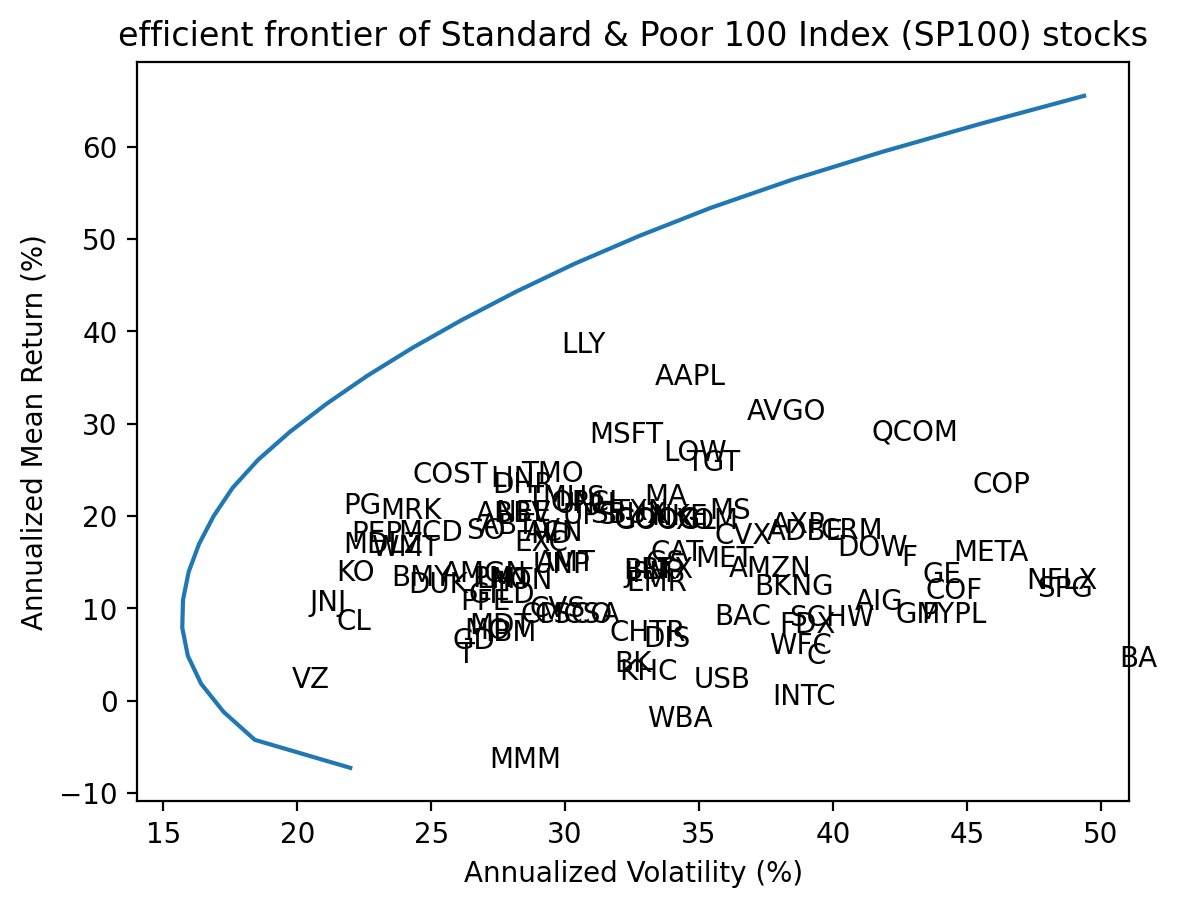

In [28]:
# Plot the efficient frontier without Bitcoin and Gold
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title('efficient frontier of Standard & Poor 100 Index (SP100) stocks')
for t, x, y in zip(
    returns.columns, 
    returns.std().mul(100*np.sqrt(252)),
    returns.mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()

With Bitcoin and Gold

In [29]:
# Set up target annualized return range for the portfolio including Bitcoin and Gold
tret2 = 252 * np.linspace(returns2.mean().min(), returns2.mean().max(), 25)

# Optimize the portfolios for target returns with Bitcoin and Gold
res_ef2 = []

for t in tret2:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(returns2.shape[1]) / returns2.shape[1], # initial portfolio weights
        args=(returns2, 252), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns2.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns2, ppy=252) - t} # constrains portfolio mean return to the target return

        )
    )
    res_ef2.append(_)

In [30]:
for r in res_ef2:
    assert r['success'] 
ef2 = pd.DataFrame(
    {
        'tret': tret2,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef2])
    }
)
ef2.head()

,tret,tvol
0,-0.05,0.18
1,-0.03,0.15
2,-0.01,0.12
3,0.01,0.11
4,0.03,0.10


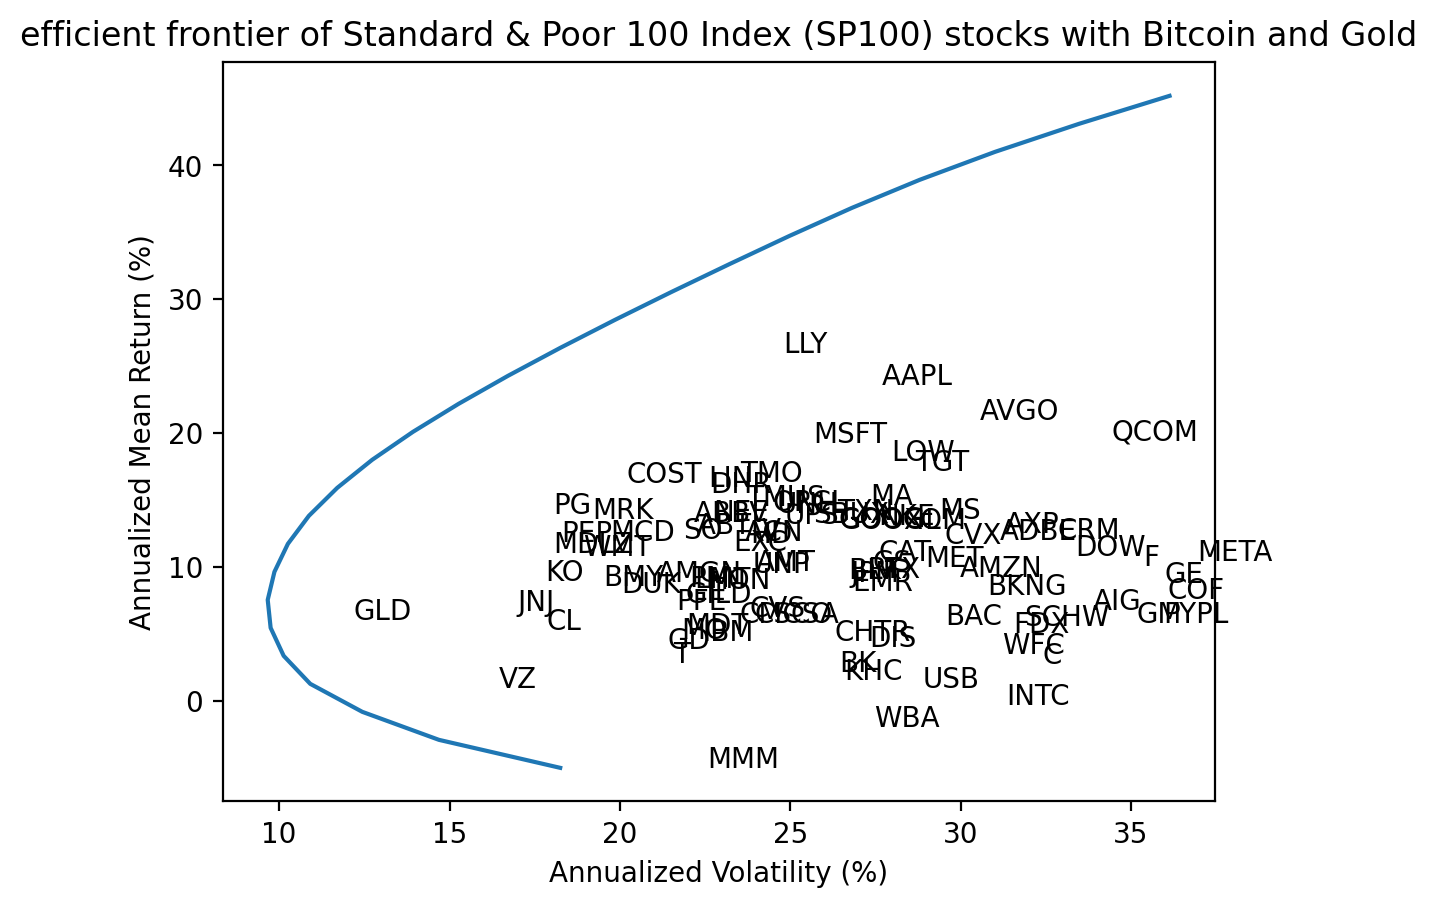

In [31]:
# Plot the efficient frontier with Bitcoin and Gold
ef2.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title('efficient frontier of Standard & Poor 100 Index (SP100) stocks with Bitcoin and Gold')
for t, x, y in zip(
    returns2.columns, 
    returns2.std().mul(100*np.sqrt(252)),
    returns2.mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()

Comment:

The efficient frontier is a concept that helps investors discover the relationship between risk and expected return for a portfolio of specific assets. It provides investors with investment recommendations for different stocks that are above the efficient frontier and have the optimal expected return and optimal risk level. The efficient frontier is a balance between return and risk. We find that most stocks in the S&P100 are concentrated below the effective front, but there are a few stocks above the effective front, such as MMM, VZ, NVDA, and TSLA, that have the best portfolios compared to stocks below the effective front, providing the greatest return for a given level of risk. After we add the historical data for Bitcoin and Gold, we find that both assets are above the effective frontier. In the chart, we can see that GLD has the lowest annualized volatility and Bitcoin has the highest return and the highest volatility.

## Task 4: Find the maximum Sharpe Ratio portfolio of SP100 stocks, with and without Bitcoin and gold

Follow the data requirements of task 3.

In [32]:
def port_sharpe(x, r, ppy, tgt):
    rp = r.dot(x) 
    er = rp.sub(tgt).dropna() 
    return np.sqrt(ppy) * er.mean() / er.std() 

In [33]:
def port_sharpe_neg(x, r, ppy, tgt):
    return -1 * port_sharpe(x, r, ppy, tgt)

In [34]:
#The maximum Sharpe Ratio portfolio without Bitcoin and Gold
max_port_wo = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns.shape[1]) / returns.shape[1],
    args=(returns, 252, 0),
    #bounds=[(0,1) for _ in range(returns2.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # want eq constraint to = 0
    )
)

max_port_wo = max_port_wo['x']
max_port_wo

array([ 0.67,  1.03, -0.04,  0.56, -0.36, -0.12,  0.04, -0.26, -0.61,
       -0.75,  0.49,  0.31, -0.55, -0.5 , -0.65,  0.39,  0.02, -0.03,
       -0.74,  1.03, -0.06, -0.2 ,  0.05,  0.5 , -0.  ,  0.38, -0.37,
       -0.99, -0.  , -0.49, -0.02, -0.26,  0.01, -0.76, -0.57, -1.09,
        0.28,  0.11,  0.05,  0.46,  0.29, -0.59,  2.5 , -2.73,  0.73,
       -0.31,  0.1 ,  0.14, -1.01, -0.04,  1.06,  0.14,  0.  ,  0.53,
        0.72,  0.5 ,  0.57, -0.  ,  0.51,  0.29, -0.63,  0.26,  0.44,
       -1.66, -0.57, -0.03,  0.73,  0.55,  0.35, -0.16, -0.39,  0.66,
        0.28, -0.26, -0.43,  0.85,  0.37, -0.97, -0.1 , -0.13,  0.17,
       -0.04,  1.65,  0.19,  0.5 ,  0.51,  0.51,  0.74,  0.49, -0.39,
       -0.14, -0.49,  0.63, -0.6 , -0.52, -1.54, -0.45, -0.46, -0.08,
        0.85])

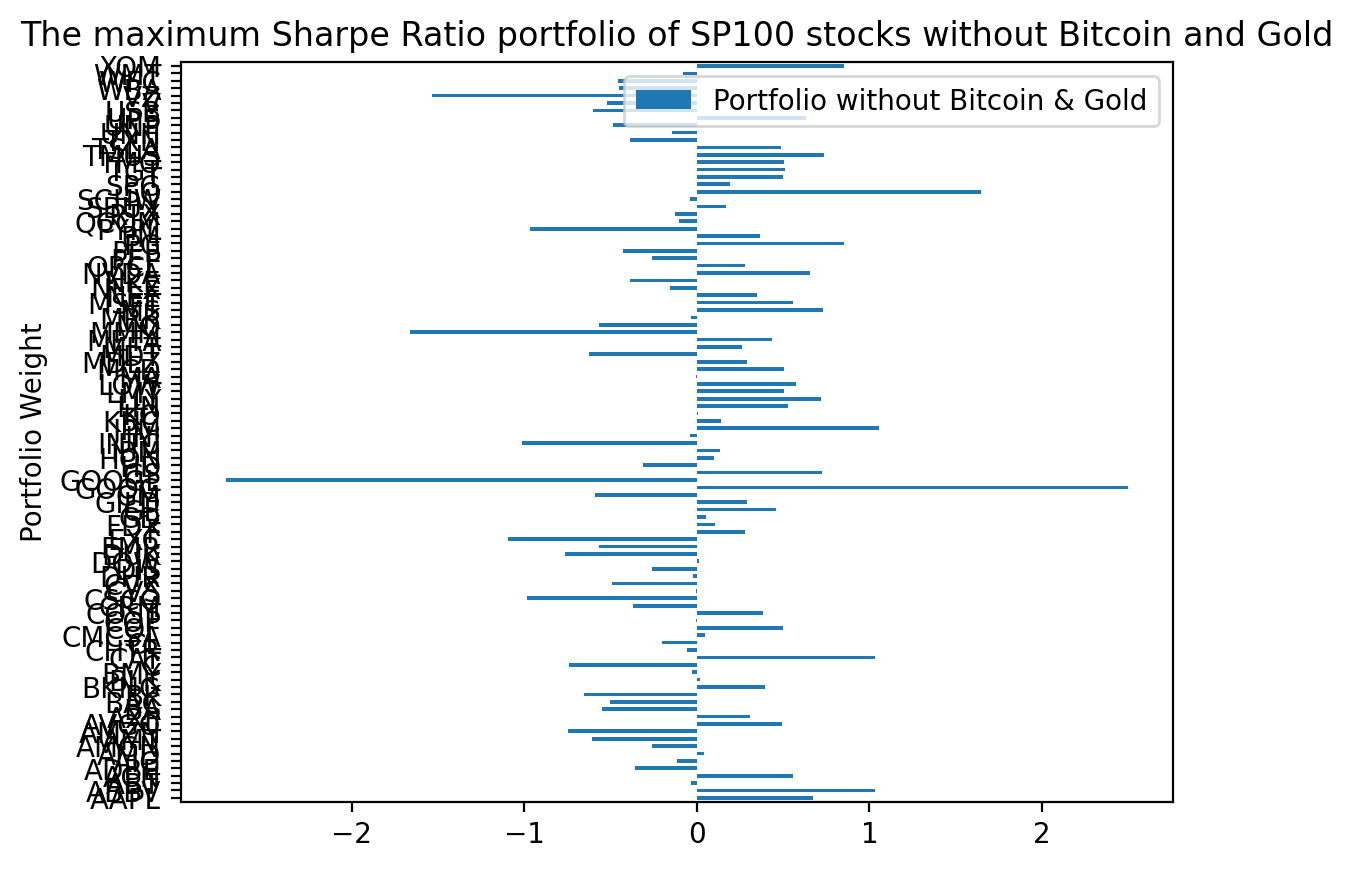

In [35]:
(
    pd.DataFrame(
        data={
            'Portfolio without Bitcoin & Gold':max_port_wo
        },
        index=returns.columns
    )
    .rename_axis('Portfolio Weight')
    .plot(kind='barh')
)
plt.title('The maximum Sharpe Ratio portfolio of SP100 stocks without Bitcoin and Gold')
plt.show()

In [36]:
max_sharpe_wo = port_sharpe(x = max_port_wo, r = returns, ppy = 252, tgt = 0)
max_sharpe_wo

3.87

In [37]:
#The maximum Sharpe Ratio portfolio with Bitcoin and Gold
max_port_with = sco.minimize(
    fun=port_sharpe_neg,
    x0=np.ones(returns2.shape[1]) / returns2.shape[1],
    args=(returns2, 252, 0),
    #bounds=[(0,1) for _ in range(returns2.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # want eq constraint to = 0
    )
)

max_port_with = max_port_with['x']
max_port_with

array([ 3.18e-01,  4.57e-01,  1.13e-03,  2.02e-01, -1.57e-01, -7.91e-02,
       -1.36e-02, -1.16e-01, -2.97e-01, -3.53e-01,  1.82e-01,  1.32e-01,
       -2.61e-01, -1.43e-01, -3.18e-01,  1.65e-01, -2.09e-02, -3.17e-02,
        1.39e-01, -3.13e-01,  3.75e-01, -3.97e-02, -2.37e-02,  3.64e-02,
        1.92e-01, -2.23e-02,  1.28e-01, -1.66e-01, -3.85e-01,  2.13e-02,
       -2.40e-01, -4.46e-02, -1.70e-01, -2.05e-02, -3.83e-01, -1.84e-01,
       -4.41e-01,  1.54e-01,  5.00e-02,  5.11e-02,  2.14e-01,  1.41e-01,
        6.15e-01, -2.74e-01,  1.13e+00, -1.25e+00,  3.28e-01, -1.14e-01,
        6.27e-02,  5.25e-02, -4.57e-01,  2.23e-02,  4.78e-01,  2.42e-02,
        5.94e-02,  1.34e-01,  3.15e-01,  1.82e-01,  2.42e-01, -3.56e-02,
        2.12e-01,  9.59e-02, -2.28e-01,  1.17e-01,  2.02e-01, -7.35e-01,
       -2.22e-01, -3.08e-02,  3.06e-01,  2.74e-01,  1.16e-01, -6.83e-02,
       -1.57e-01,  3.00e-01,  1.11e-01, -1.14e-01, -1.69e-01,  3.38e-01,
        1.24e-01, -4.21e-01, -5.11e-02, -2.09e-02, 

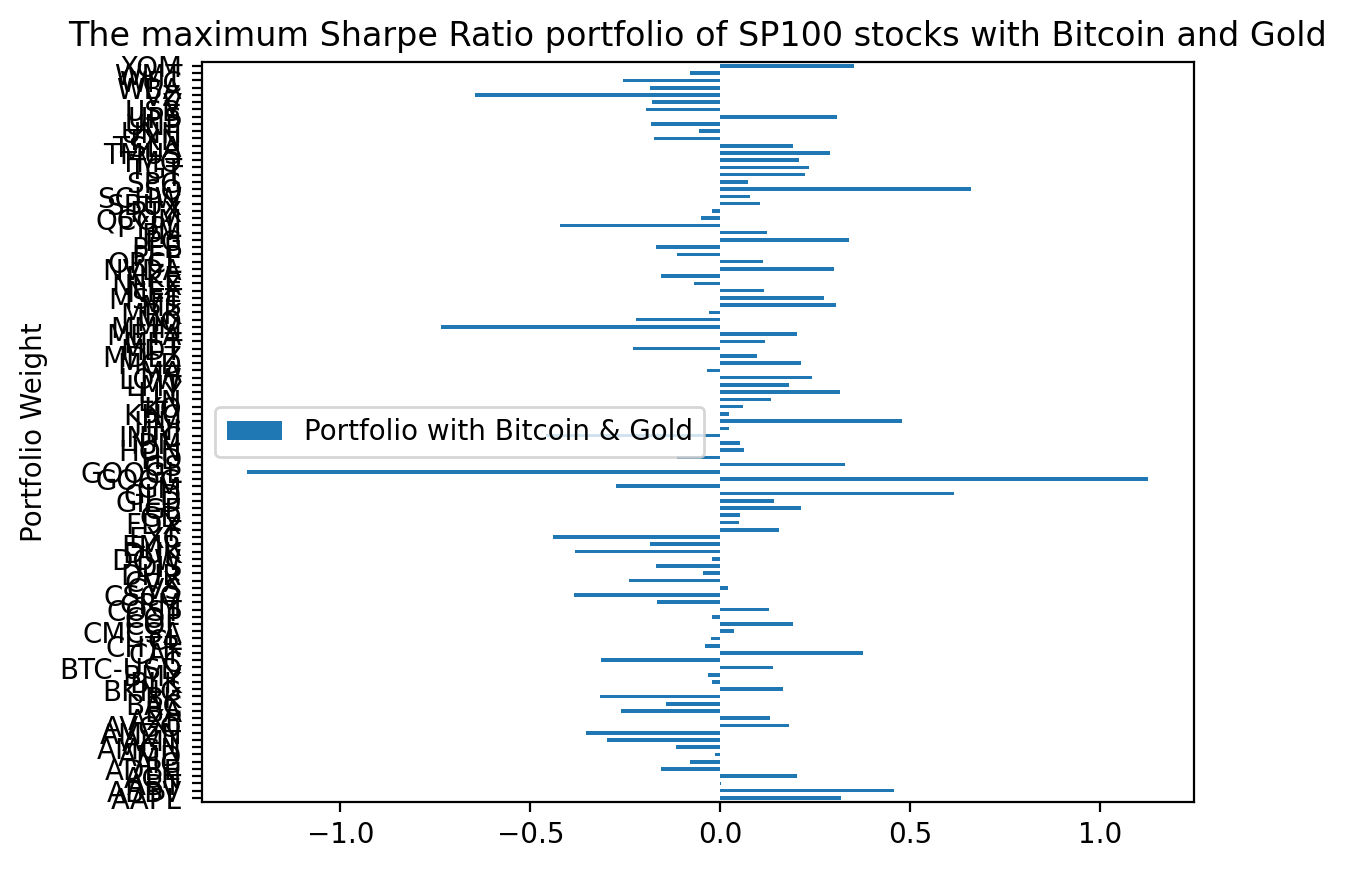

In [38]:
(
    pd.DataFrame(
        data={
            'Portfolio with Bitcoin & Gold':max_port_with
        },
        index=returns2.columns
    )
    .rename_axis('Portfolio Weight')
    .plot(kind='barh')
)
plt.title('The maximum Sharpe Ratio portfolio of SP100 stocks with Bitcoin and Gold')
plt.show()

In [39]:
max_sharpe_with = port_sharpe(x = max_port_with, r = returns2, ppy = 252, tgt = 0)
max_sharpe_with

3.32

Comment:

For the portfolio excluding Bitcoin and gold, we calculated the weights for the maximum Sharpe ratio portfolio. Since we wanted to calculate a more accurate weight, we did not set bounds in the calculation, because this would allow Calculate the weight of each indicator of the portfolio with the maximized Sharpe ratio. And, for this portfolio, its maximum Sharpe ratio is 3.87.
For the portfolio including Bitcoin and gold, we also use the bounds-free range to calculate the weight of each indicator. And, for this portfolio, its maximum Sharpe ratio is 3.32.
However, comparing two different portfolios according to the drawing, it can be found that even including Bitcoin and gold, the holdings with the largest weight are almost the same several stocks. Therefore, it can be said that these stocks have performed very strongly during this period.

## Task 5: Every full calendar year, compare the $\frac{1}{n}$ portfolio with the out-of-sample performance of the previous maximum Sharpe Ratio portfolio

Follow the data requirements of task 3.
Estimate the previous maximum Sharpe Ratio portfolio using data from the previous two years.
Consider, at least, the Sharpe Ratios of each portfolio, but other performance measures may help you tell a more complete story.

In [40]:
def optimize_portfolio(r, fun, bounds, constraints):
    res_mv = sco.minimize(
        fun=fun,
        x0=np.ones(r.shape[1]) / r.shape[1],
        args=(r, 252, ff['RF']),
        bounds=bounds,
        constraints=constraints
    )
    return res_mv['x']

In [41]:
def get_annual_returns(r):
    return r.add(1).resample('A').prod().sub(1)

# Def Calculate the annual returns for the 1/n portfolio
def compute_equal_weighted_returns(r, annual_returns):
    x0 = np.ones(r.shape[1]) / r.shape[1]
    return annual_returns.dot(x0).to_frame(name='1/N Portfolio')

In [42]:
# Def Annualize Sharpe ratio portfolio returns
def compute_annualized_sharpe_returns(r, annual_returns, col_name):
    weights_data = []
    weights_index = []

    for i in annual_returns.index:
        weights_index.append(i)
        year_i_returns = r.loc[i.strftime('%Y')]
        k = optimize_portfolio(year_i_returns, port_sharpe_neg, [(0, 1) for _ in range(r.shape[1])], [{'type': 'eq', 'fun': lambda x: x.sum() - 1}])
        weights_data.append(k)

    a_s_weights = pd.DataFrame(data=weights_data, index=weights_index, columns=r.columns)
    return (annual_returns * a_s_weights.shift(1)).sum(axis=1).to_frame(name=col_name)

In [43]:
# Def Calculate the data for the comparison of 1/n portfolio and previous maximum Sharpe ratio portfolio
def calculate_comparison_data(returns, col_name):
    sp100_a_r = get_annual_returns(returns)
    eqwp_a_r = compute_equal_weighted_returns(returns, sp100_a_r)
    sharpe_a_r = compute_annualized_sharpe_returns(returns, sp100_a_r, col_name)

    combo = pd.concat([eqwp_a_r, sharpe_a_r], axis=1).iloc[1:].mul(100)
    combo.index = combo.index.year
    return combo

In [44]:
# Def Plot the comparison of 1/n portfolio and previous maximum Sharpe ratio portfolio using the calculated data
def plot_comparison_from_data(data, col_name):
    data.plot(kind='bar')
    plt.title('Compare the Performance of 1/N Portfolio and \nPrevious Maximum Sharpe Ratio Portfolio of \nSP100 ' + col_name)
    plt.ylabel('Annualized Mean Return (%)')
    plt.show()

In [45]:
# Calculate the data using inputs (SP100 & SP100 + Bitcoin + Gold) got from task 3
comparison_without_btc_gold_data = calculate_comparison_data(returns, 'Previous Max S.R. Portfolio Without Bitcoin & Gold')
comparison_with_btc_gold_data = calculate_comparison_data(returns2, 'Previous Max S.R. Portfolio With Bitcoin & Gold')

# Print out the data
print("\nComparison Without BTC and Gold:")
print(comparison_without_btc_gold_data)
print("\nComparison With BTC and Gold:")
print(comparison_with_btc_gold_data)


Comparison Without BTC and Gold:
      1/N Portfolio  Previous Max S.R. Portfolio Without Bitcoin & Gold
Date                                                                   
2019          30.96                                              30.96 
2020          24.09                                              39.07 
2021          29.42                                              38.88 
2022         -10.18                                             -12.09 
2023           5.97                                               4.53 

Comparison With BTC and Gold:
      1/N Portfolio  Previous Max S.R. Portfolio With Bitcoin & Gold
Date                                                                
2019          31.43                                            31.43
2020          26.83                                            35.73
2021          29.38                                            47.55
2022         -10.61                                           -12.09
2023           6.

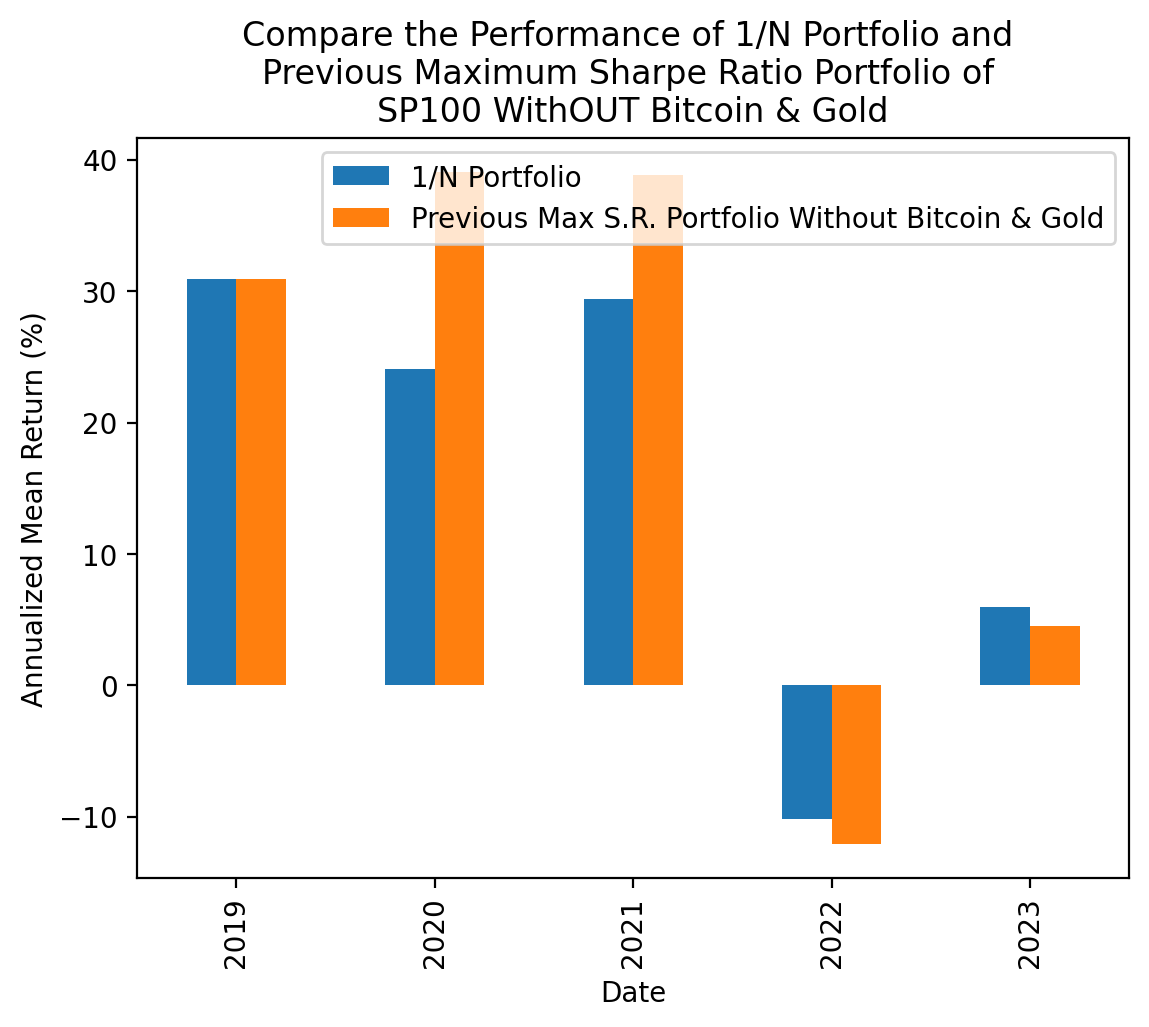

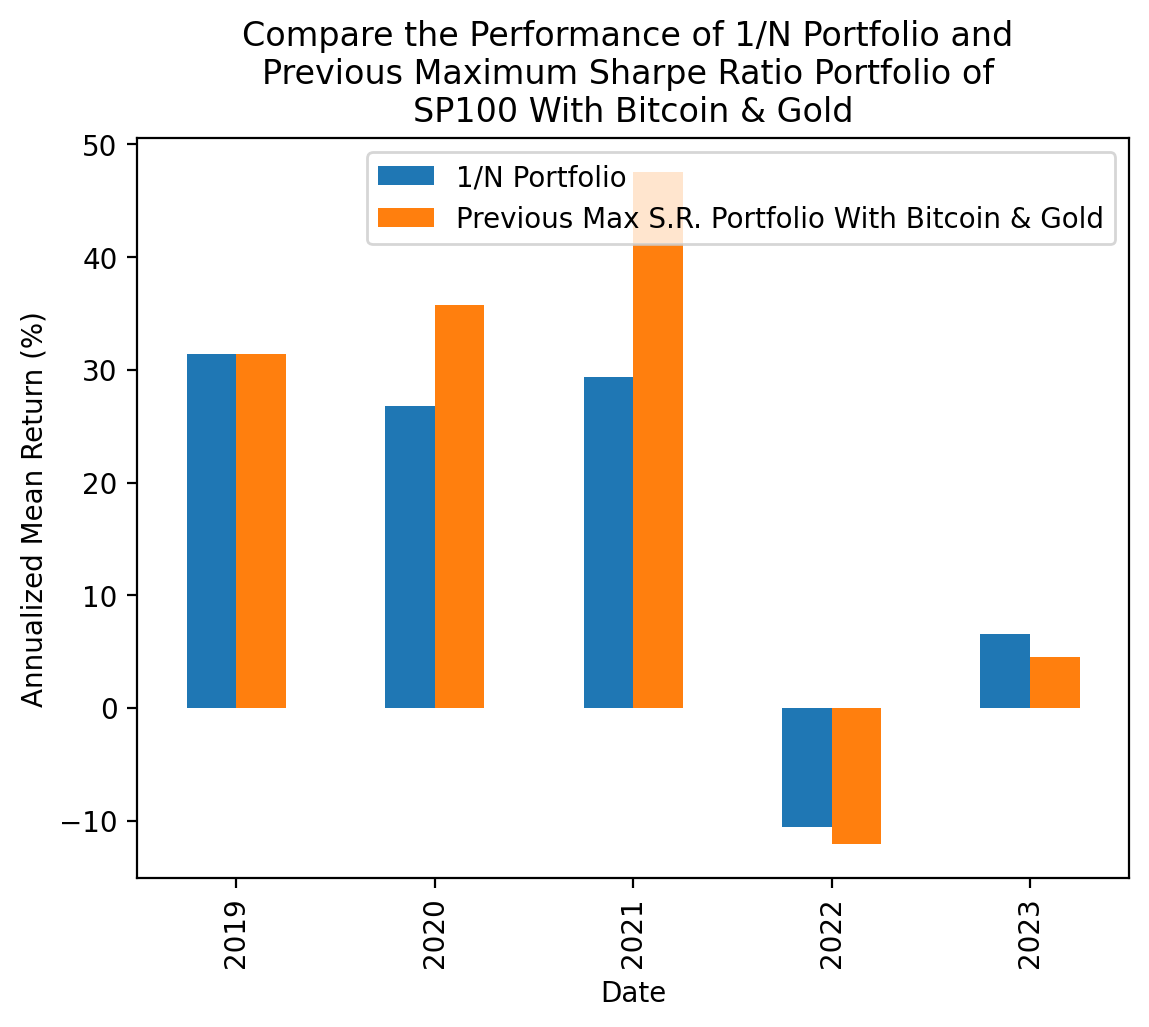

In [46]:
# Plot the data
plot_comparison_from_data(comparison_without_btc_gold_data, 'WithOUT Bitcoin & Gold')
plot_comparison_from_data(comparison_with_btc_gold_data, 'With Bitcoin & Gold')

Comment:

In this task, we did a 2-by-2 comparison for the performance of two types of portfolios for the SP100 stocks: equal-weighted 1/N portfolio and the previous maximum Sharpe Ratio portfolio. It does this for two scenarios: without Bitcoin and Gold, and with Bitcoin and Gold. From the data and comparison charts shown above, overall, we see a significant performance/return premium of Previous Maximum Sharpe Ratio Portfolio in comparison with the equal-weighted 1/N portfolio. On the other hand, we see no significant performance/return premium with bitcoin and gold added to the SP100 portfolio against the one without bitcoin or gold, but overall there is a slight improvement with bitcoin and gold added.

## Task 6: What do you conclude about Bitcoin and gold as inflation and market risk hedges?

What are your overall conclusions and limitations of your analysis?
What do the data suggest about the article that motivated this project?
Please see the link at the top of this notebook.

Comment:

Based on the findings above, we can conclude that neither Bitcoin nor gold can be considered effective hedges against inflation, as their correlation with the rate of change in inflation is not strong enough. However, gold appears to be a better hedge against market risk than Bitcoin, as it has a much lower CAPM beta value, indicating less volatility and less correlation to the overall market. 

The efficient frontier analysis shows that including Bitcoin and gold in a portfolio can improve the risk-return relationship by expanding the the curve, or, shifting it upwards/leftwards. This means that the optimal expected return and optimal risk level can be achieved with these assets. When constructing a long-only maximum Sharpe ratio portfolio, including Bitcoin and gold makes the portfolio more diversified. Comparing the performance of the equal-weighted 1/N portfolio and the previous maximum Sharpe Ratio portfolio, we observe a significant performance/return premium for the latter. The addition of Bitcoin and gold to the portfolio leads to a slight improvement in the overall performance, although no significant performance/return premium is observed.

Here's our takeaway from the project: Bitcoin and gold are not ideal hedges against inflation risk, and gold is a better hedge against market risk than Bitcoin. Including these assets in a portfolio may lead to slight improvements in the overall risk-return relationship but does not guarantee significant performance/return premiums. Overall, we should still remain cautious about the effectiveness of Bitcoin as a hedge, considering its relatively new status in the market and potential future changes in market conditions such as volatility, demand, and liquidity. However, we need to keep our minds open-ended since bitcoin and cryptocurrencies are still relatively new and the fundamental-side of cryptocurrencies may change our perceptions on how investments should be allocated altogether, especially given the new concepts and emerging ideas related to cryptocurrencies and blockchain like Web3.

# Criteria

1. ***Discuss and explain your findings for all 6 tasks, and be specific!***
1. ***Your goal is to convince me of your calculations and conclusions***
1. All tasks are worth 16.67 points each
1. Your report should not exceed 25 pages
1. Here are more tips
    1. Each task includes suggestions
    1. I suggest you include plots and calculations for all but the last task
    1. Remove unnecessary code, outputs, and print statements
    1. Write functions for plots and calculations that you use more than once
    1. I will not penalize code style, but I will penalize submissions that are difficult to follow or do not follow these instructions
1. How to submit your project
    1. Restart your kernel, run all cells, and save your notebook
    1. Export your notebook to PDF (`File > Save And Export Notebook As ... > PDF` in JupyterLab)
        1. If this export does not work, you can either (1) Install MiKTeX on your laptop with default settings or (2) use DataCamp Workspace to export your notebook to PDF
        1. You do not need to re-run your notebook to export it because notebooks store output cells
    1. Upload your notebook and PDF to Canvas
    1. Upload your PDF only to Gradescope and tag your tasks and teammates
    1. Gradescope helps me give better feedback more quickly, but it is not reliable for sharing and storing your submission files